In [1]:
%matplotlib inline
import sys
import matplotlib
import random
from random import randint
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.constraints import maxnorm
#from keras import optimizers
from keras.models import Sequential
import matplotlib
matplotlib.use('TKAgg')
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import keras
from keras import layers
from keras.regularizers import l2
from keras.layers import Dropout

import statistics
from copy import deepcopy
import seaborn as sb
import os
import matplotlib.gridspec as gridspec

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold


from sklearn.ensemble import IsolationForest



import pandas as pd

Using TensorFlow backend.


In [2]:
#validation_split = 82000
#validation_split = 53400
validation_split = 8000
#limit = 10000

test = './data_test.csv'
train = './training_48.csv'
#train =  './bscgrid31_training_equalized_46.csv'
train_file_location = './bscgrid31_training_42.csv'
#train_file_location =  './bscgrid31_training_equalized_46.csv'
validation_dir = './validation_pca/'
sample = 'original_data_1000.csv'
weights = 'y_weights.csv'


df = pd.read_csv(train_file_location)
#df = pd.read_csv(sample)
weights = pd.read_csv(weights)
#df = df.drop(['Unnamed: 0'],1)

print(df.shape)
weights = weights.drop(['RETIRED_UOPS'],1);
weights = weights.values
print(weights.shape)

#df.dropna()

(102967, 43)
(10000, 13)


# Random Forest selection

In [ ]:
max = df.max()
min = df.min()
df = (df-min)/(max-min)
#df_values = df.values
df_scaled = (df-min)/(max-min)
df_values = df_scaled.values
train_data = df_values[:validation_split,1:]
y_train = df_values[:validation_split,0]
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(train_data,y_train)

In [ ]:
df = df.drop(['powerWatts'],1)
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Covariate Shift method

In [ ]:
test = pd.read_csv(test)
train = pd.read_csv(train)

print(test.columns)
test = test.drop(['Unnamed: 0'],axis=1)
test = test.drop(['powerWatts'], axis = 1)

train = train.drop(['Unnamed: 0'],axis=1)
train = train.drop(['powerWatts'], axis = 1)

test['origin'] = 0
train['origin'] = 1

training = train.sample(7662, random_state=12)
testing = test.sample(7000, random_state=11)

## combining random samples
combi = training.append(testing)
y = combi['origin']
combi.drop('origin',axis=1,inplace=True)
combi.drop('app',axis=1,inplace=True)
combi.drop('type',axis=1,inplace=True)

print(combi)

## modelling
model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
drop_list = []
for i in combi.columns:
    score = cross_val_score(model,pd.DataFrame(combi[i]),y,cv=2,scoring='roc_auc')
    if (np.mean(score) > 0.9):
        drop_list.append(i)
    print(i,np.mean(score))

combi.drop(drop_list,axis=1,inplace=True)

print(combi.columns)

# Variance selection

In [10]:
max = df.max()
min = df.min()
df_scaled = (df-min)/(max-min)
#df_scaled = df
novar_features = []
#print(df_scaled.var())
for columns in df_scaled.columns:
    if df_scaled[columns].var()<0.001:
        print(columns)
        print(df_scaled[columns].var())
        novar_features.append(columns)
print(novar_features)
df = df.drop(novar_features,1)
print(df.shape)
print(df.columns)

[]
(10000, 13)
Index(['powerWatts', 'contexts', 'instructions', 'cpu.cycles', 'branches',
       'branch.misses', 'L1.icache.loads', 'L1.dcache.loads', 'REQUESTS_TO_L2',
       'RETIRED_UOPS', 'bytes_out', 'cpu_idle', 'cpu_system'],
      dtype='object')


# Training data processing and correlation matrix

(102967, 42)
Index(['powerWatts', 'contexts', 'instructions', 'cpu.cycles', 'branches',
       'branch.misses', 'L1.icache.loads', 'L1.dcache.loads', 'REQUESTS_TO_L2',
       'RETIRED_UOPS', 'bytes_out', 'cpu_idle', 'cpu_system'],
      dtype='object')


/home/bscuser/anaconda3/envs/dl/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(102967, 13)


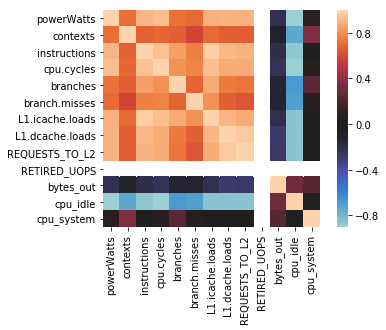

In [7]:


print(df.shape)
#print(df.sum()/len(train)*100)

#Drop non variace features
#df = df.drop(['read_time', 'reads','page_in','cpu_intr','cpu_nice'], axis = 1)

#Drop non correlated features
#df = df.drop(['Unnamed: 0','writes','bytes_in', 'pkts_in','write_time','mem_cached','mem_buffers','bytes_out','pkts_out','cpu_wio','page_out','cpu_system'], axis = 1)

tranformed_columns = ['powerWatts', 'contexts', 'instructions', 'cpu.cycles', 'branches', 'branch.misses', 'L1.icache.loads',
                      'L1.dcache.loads', 'REQUESTS_TO_L2', 'RETIRED_UOPS', 'bytes_in', 'bytes_out', 'pkts_in', 'pkts_out']#12 features
tranformed_columns2 = ['powerWatts', 'contexts', 'instructions', 'cpu.cycles', 'branches', 'branch.misses', 'L1.icache.loads',
                       'L1.dcache.loads', 'REQUESTS_TO_L2', 'RETIRED_UOPS', 'bytes_out', 'cpu_idle', 'cpu_system']#9 features  'L1.icache.loads'
tranformed_columns3 = ['powerWatts','DISPATCHED_FPU_OPS', 'L1.dcache.loads', 'L1.icache.load.misses',
       'L1.icache.loads', 'L2_CACHE_MISS', 'LLC.load.misses', 'LLC.stores',
       'MEMORY_REQUESTS', 'REQUESTS_TO_L2', 'RETIRED_MMX_FP_INSTRUCTIONS_MMX',
       'RETIRED_MMX_FP_INSTRUCTIONS_SSE', 'RETIRED_MMX_FP_INSTRUCTIONS_X87',
       'RETIRED_SSE_OPS', 'RETIRED_UOPS', 'branch.misses', 'branches',
       'bytes_in','contexts', 'cpu.cycles',
       'cpu.migrations', 'cpu_idle', 'cpu_intr', 'cpu_nice', 'cpu_sintr',
       'cpu_system', 'cpu_wio', 'instructions',
       'interrupts', 'page_in', 'page_out', 'pkts_out', 'read_time', 'reads',
       'write_time', 'writes']

tranformed_columns = ['powerWatts','RETIRED_UOPS','cpu.cycles','DISPATCHED_FPU_OPS','cpu_idle','L1.dcache.loads']
#tranformed_columns = ['powerWatts', 'contexts', 'instructions', 'cpu.cycles', 'branches', 'branch.misses', 'L1.icache.loads',
                      #'L1.dcache.loads', 'REQUESTS_TO_L2', 'RETIRED_UOPS','cpu_idle']
df = df.loc[:,tranformed_columns2]

#df = df.drop(['Unnamed: 0'],axis=1)
#df = df.drop(drop_columns,axis=1)

df_columns = df.columns
print(df_columns)

#Correlation Matrix with normalized data
#df_norm=(df-df.mean())/df.std()

C_mat = df.corr(method = 'spearman')
fig = plt.figure()

sb.heatmap(C_mat, vmax = 1, square = True, center=0)
#plt.show()

print(df.shape)
#df = df.values

# Visual selection

In [ ]:
drop_columns = [
'read_time',
'mem_buffers',
'mem_cached',
'page_in',
'page_out',
'pkts_in',
'pkts_out',
'cpu_nice',
'cpu_sintr'
]

df = df.drop(drop_columns,axis=1)

df_columns = df.columns

# Outliers deletion

In [ ]:
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(df)
y_noano = clf.predict(df)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

df = df.iloc[y_noano[y_noano['Top'] == 1].index.values]
df.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", df.shape[0])

# High intercorrelation features drop

In [ ]:
print(df.columns)
high_corr = []
C_mat = df.corr(method = 'spearman')
#print(C_mat)
count = 0
for i in range(0,len(df.columns)):
    for j in range(count,len(df.columns)):
        if i != j and i != 0:# and j != 'powerWatts':# and i != 'instructions' and j != 'instructions':
            if abs(C_mat.iloc[i][j]) > 0.8:
                high_corr.append((i,j))
    count += 1
    #print(i)
for i in range(0,len(high_corr)):
    print(df.columns[high_corr[i][0]],df.columns[high_corr[i][1]])
#print(df.columns[high_corr[0]],df.columns[high_corr[1]])
df_columns = df.columns
#df = df.drop(['contexts','instructions','cpu.cycles','L1.icache.loads','L1.dcache.loads','REQUESTS_TO_L2','RETIRED_UOPS','L1.dcache.load.misses'],1)


In [ ]:
traget_corr = []
#C_mat = df.corr(method = 'spearman')
for i in df.columns:
    #print(C_mat['powerWatts'][i])
    if abs(C_mat['powerWatts'][i]) > 0.5:
        high_corr.append(i)

print(high_corr)
#fig = plt.figure()
#sb.heatmap(C_mat, vmax = 1, square = True, center=0)


In [ ]:
df = df.drop(['contexts','instructions','cpu.cycles','L1.icache.loads','L1.dcache.loads','REQUESTS_TO_L2','RETIRED_UOPS'],1)
df_columns = df.columns

In [3]:
df = df.drop(['RETIRED_UOPS'],1);
#df = df.drop(['cpu_system'],1);
df_columns = df.columns

# Test data processing and correlation matrix

In [ ]:
i = 1
#ig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.001)
#axs = axs.ravel()
for filename in os.listdir(validation_dir):
    #if filename == 'data_caching.csv':#Choose file name of test application
        test_df_orig = pd.read_csv(os.path.join(validation_dir, filename))
        #print(test_df_orig)
        #test_df_orig = test_df_orig.drop(['timestamp'],axis=1)

        test_df = test_df_orig.loc[:,df_columns]

        test_df_norm=(test_df-test_df.mean())/test_df.std()

        C_mat = test_df_norm.corr(method = 'spearman')
        
        #plt.subplots(i,1,figsize=(15,15))
        
        
        fig = plt.figure()
        plt.title(filename)
        
        
        sb.heatmap(C_mat, vmax = 1, square = True, center=0)
        #axs[1].plot(plt.figure())
        i+=1
#plt.figure(figsize=(20,10))
#plt.show()

#plt.subplots(2,2,figsize=(15,15))

In [4]:
print(df.columns.shape)
print(df_columns)
#print(x_train.shape)
print(weights.shape)

(42,)
Index(['Unnamed: 0', 'powerWatts', 'contexts', 'instructions', 'cpu.cycles',
       'cpu.migrations', 'branches', 'branch.misses', 'L1.icache.loads',
       'L1.icache.load.misses', 'L1.dcache.loads', 'L1.dcache.load.misses',
       'LLC.loads', 'LLC.load.misses', 'LLC.stores', 'DISPATCHED_FPU_OPS',
       'L2_CACHE_MISS', 'MEMORY_REQUESTS', 'REQUESTS_TO_L2',
       'RETIRED_MMX_FP_INSTRUCTIONS_MMX', 'RETIRED_MMX_FP_INSTRUCTIONS_SSE',
       'RETIRED_MMX_FP_INSTRUCTIONS_X87', 'RETIRED_SSE_OPS', 'read_time',
       'write_time', 'reads', 'writes', 'mem_buffers', 'mem_cached', 'page_in',
       'page_out', 'bytes_in', 'bytes_out', 'pkts_in', 'pkts_out', 'cpu_idle',
       'cpu_intr', 'cpu_nice', 'cpu_sintr', 'cpu_system', 'cpu_wio',
       'interrupts'],
      dtype='object')
(10000, 13)


# Neural network model

In [5]:
batch_size = 32#20
num_epochs = 60

def build_model():
    model = Sequential()
    #input_shape
    #model.add(Dropout(0.2, input_shape=(24,)))
    model.add(Dense(28, input_shape=(11,), activation='relu',kernel_initializer='normal', kernel_regularizer=l2(0.005)))#, kernel_regularizer=l2(0.02), kernel_constraint=maxnorm(3)
    #model.add(Dense(64, activation='relu',kernel_initializer='normal'))
    #model.add(layers.BatchNormalization())
    model.add(Dense(64, activation='relu',kernel_initializer='normal'))
    #model.add(Dropout(0.8))
    #model.add(layers.BatchNormalization())
    #model.add(Dense(64, activation='relu',kernel_initializer='normal'))
    #model.add(Dense(128, activation='relu',kernel_initializer='normal',kernel_constraint=maxnorm(3)))
    #model.add(Dense(128, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,activation='linear',kernel_initializer='normal'))
    model.summary()
    model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.01),metrics=['mape'])#mean_absolute_error
    #model.compile(loss='mse', optimizer=RMSprop(lr=learning_rate),metrics=['mae'],) #mse
    return model

def train_model():
    
    history = model.fit(x_train, y_train, batch_size=batch_size,
                epochs=num_epochs, verbose=1,validation_data = (x_val,y_val), sample_weight=weights[2],
                callbacks=callbacks_list)#sample_weight=weights,
    #val_mse, val_mae = model.evaluate(x_test, y_test,
                    #verbose=1)
    #print('val_mse: ',val_mse)
    #print('val_mae: ',val_mae)
model = 0

model = build_model()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28)                336       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [6]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_mean_absolute_percentage_error',
    patience=100,
    ),
    
    keras.callbacks.ModelCheckpoint(
    filepath='model_transformed_4l_25f_v2.h5',
    monitor='val_mean_absolute_percentage_error',
    save_best_only=True,),
    
    keras.callbacks.TensorBoard(log_dir='./log_nn',
    histogram_freq=1,
    embeddings_freq=0,
    write_graph=True,
    write_images=False)
    ]
#tbCallBack = TensorBoard(log_dir='./log_nn', histogram_freq=1, embeddings_freq=0,write_graph=False, write_images=False)
#tensorboard --logdir='./log_nn'

#print('Train features', list(df.columns))

df = df.values

nFeatures = df.shape[1]-1
print('nFeatures: ',nFeatures)

#################################################################################################################################

#Randomize training data
random_index = []
a = np.arange(len(df))
np.random.shuffle(a)
random_index = a[:len(df)]
print(random_index)

df_orig = deepcopy(df)
##########
weights_orig = deepcopy(weights)

i=0
for j in random_index:
    df[i] = df_orig[j]
    weights[i] = weights_orig[j]
    i += 1


train_data = weights[:validation_split,2:]
val_data = weights[validation_split+1:,2:]

#max = train_data.max()
#min = train_data.min()
#train_data = (train_data-min)/(max-min)

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

#print(mean)
#print(std)

#val_data = (val_data-min)/(max-min)
val_data -= mean
val_data /= std


#print('df: ', df)
#print('train_data', train_data)

x_train = train_data
x_train = x_train.astype('float32')
#print("x_train", x_train)

x_val = val_data
x_val = x_val.astype('float32')

y_train = weights[:validation_split,0]
#y_scaler = MinMaxScaler()
#y_scaler.fit(y_train)
#y_train = prepro.transform(y_train)

# y_train = train_data[:,1]
# y_train = y_train*std_power + mean_power
y_train = y_train.astype('float32')

y_val = weights[validation_split+1:,0]
#y_val = prepro.transform(y_val)
#y_val = y_val.astype('float32')

#print("y_train", y_train)
#print("y_train1", y_train)

train_model()

model.save('model_transformed_4l_25f_v2.h5')

nFeatures:  41
[102158  47402  82671 ...  97610  69991   8507]


IndexError: index 102158 is out of bounds for axis 0 with size 10000

# Randomize, mean and std to perform test directly

In [2]:
df = df.values#Numpy array
#Randomize training data
random_index = []
a = np.arange(len(df))
np.random.shuffle(a)
random_index = a[:len(df)]

df_orig = deepcopy(df)

i=0
for j in random_index:
    df[i] = df_orig[j]
    i += 1

nFeatures = df.shape[1]-1
print('nFeatures: ',nFeatures)

#Data normalization
train_data = df[:validation_split,1:]#Used for normalizing testing data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

NameError: name 'df' is not defined

# Prediction outputs

In [8]:
validation_dir = './validation_pca/'

counter = 0
mape_arr = []
for filename in os.listdir(validation_dir):
    if filename.endswith(".csv"): 
        test_df_orig = pd.read_csv(os.path.join(validation_dir, filename))

        test_df = test_df_orig.loc[:,df_columns]
        test_df = test_df.values#Change to numpy array


        test_data = test_df[:,1:]#Get only test features
        
        #Use training mean and std
        #test_data = (test_data-min)/(max-min)
        test_data -= mean
        test_data /= std

        #test_data = prepro.transform(test_data)


        x_test = test_data
        
        x_test = x_test.astype('float32')
        y_test = test_df[:,0]
        
        #print(y_test)
        #print(x_test)

        ##########################################################################
        #Model test
        ##########################################################################
        loaded_model = load_model('model_transformed_4l_25f_v2.h5')
        model = loaded_model

        val_mse, val_mae = model.evaluate(x_test, y_test,
                        verbose=0)
                        
        print('%s MAPE: ' % filename, round(val_mae,2))
        
        mape_arr.append(val_mae)

        prediction_arr = []

        for i in range(0,len(x_test)):
                newdf = x_test[i,:]
                newdf = newdf.reshape(nFeatures,1).T
                prediction = model.predict(newdf)
                prediction = prediction.reshape(1)

                prediction_arr.append(prediction)
        if counter == 0:
                predictions_df = pd.DataFrame(prediction_arr, columns=[filename[:-4]])
        else:
                predictions_df2 = pd.DataFrame(prediction_arr, columns=[filename[:-4]])
                predictions_df = pd.merge(predictions_df, predictions_df2, how='outer',left_index=True,right_index=True)
                

        counter +=1
#predictions_df.to_csv('predictions_4l_0.02.csv', sep=',')
print('Avg MAPEs. ', round(np.mean(np.asarray(mape_arr)),2))


data_analytics.csv MAPE:  14.22
graph_analytics.csv MAPE:  12.18
NAS_SER_bt_C.csv MAPE:  4.11
NAS_MPI_bt_C.csv MAPE:  3.62
software_testing.csv MAPE:  5.25
NAS_OMP_sp_D.csv MAPE:  6.28
NAS_MPI_lu_C.csv MAPE:  17.13
web_search.csv MAPE:  4.89
media_streaming.csv MAPE:  6.11
NAS_SER_sp_C.csv MAPE:  6.44
NAS_MPI_sp_C.csv MAPE:  12.53
web_serving.csv MAPE:  4.6
data_serving.csv MAPE:  9.08
NAS_SER_lu_C.csv MAPE:  7.43
data_caching.csv MAPE:  7.45
Avg MAPEs.  8.09


In [9]:
print(np.asarray(mape_arr))
print(round(np.mean(np.asarray(mape_arr)),2))

[13.12252519  7.03912515  6.36134226  6.75744075  8.10847404  4.90273436
 10.42566191  3.07596261 18.59967085  8.49864194 16.71627828 20.55262326
 10.0380086   6.76395805  4.59350496]
9.7


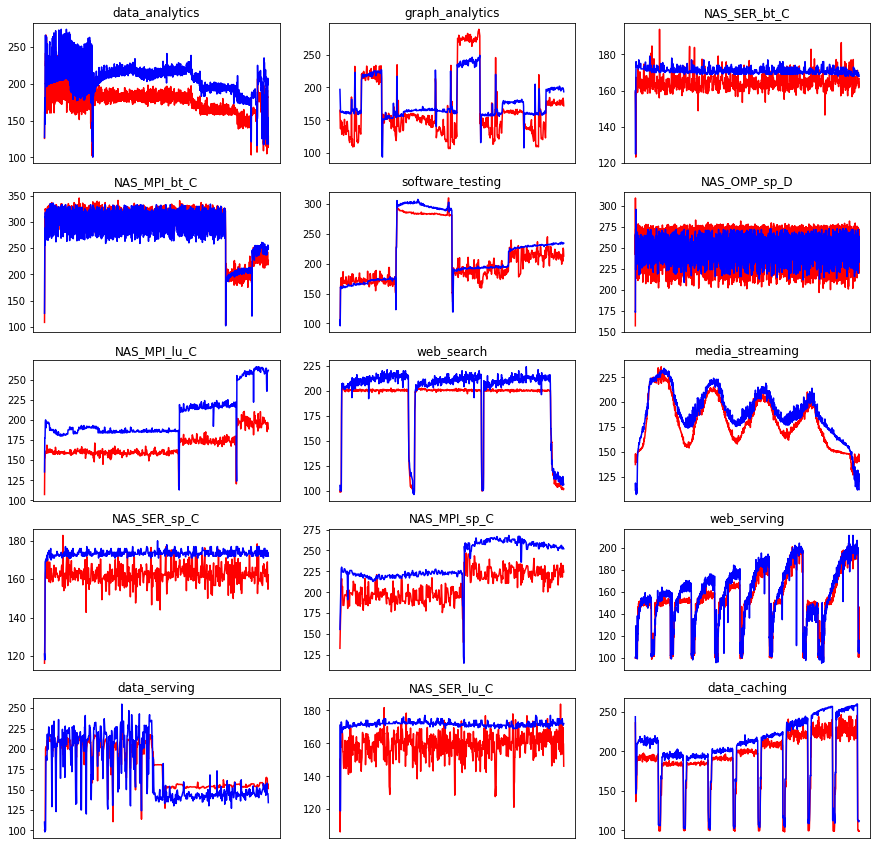

In [9]:
predictions_df.columns
fig = plt.figure(1)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout() 

i=1
for pred_app in predictions_df:
    plt.subplot(5, 3,i,title=pred_app,xticks=[])
    
    
    orig = pd.read_csv(os.path.join(validation_dir, pred_app + '.csv'))
    consumption_app = orig['powerWatts']
    #print(consumption_app.count())
    
    pred_app = predictions_df[pred_app]

    pred_app = pred_app.loc[1:consumption_app.count()-1,]
    consumption_app = consumption_app.loc[1:consumption_app.count()-1,]

    x = np.linspace(0, consumption_app.count(), consumption_app.count())

    plt.plot(x, pred_app, color = 'red')
    plt.plot(x, consumption_app, color = 'blue');
    i += 1

In [12]:
i=0
for layer in model.layers:
    if i == 0:
        weights = layer.get_weights()
    print(weights)

[array([[ 7.78157637e-02,  5.95044196e-02,  2.33181896e+01,
         1.65601776e+02,  6.64140991e+02,  5.11036860e-03,
         1.45805841e-02,  1.38459106e+02, -6.48131128e-03,
         1.75509567e+02, -1.17972065e-02,  6.00436218e+02,
         1.93902039e+02,  9.36170292e+00,  7.85728455e+01,
         2.21980743e+02, -1.13308970e-02,  1.61866684e+02,
         9.03395004e+01, -5.92213161e-02, -1.35197759e-01,
         1.49174911e+02,  3.16983978e+02,  3.91658060e-02,
         1.04648857e+02,  5.92400635e+02, -2.45389175e-02,
         3.00026207e+01],
       [-7.45726228e-02, -5.14650382e-02, -1.38308859e+00,
        -5.75741243e+00,  1.88102376e+00, -7.75583088e-03,
        -4.56280857e-02,  8.81490827e-01, -1.65837124e-01,
        -1.10722446e+00, -5.75841777e-03, -4.03789401e-01,
        -4.77783829e-01, -7.00293922e+00, -6.06037855e+00,
        -5.06094933e+00, -4.65605296e-02, -6.74956441e-01,
         3.13136721e+00, -3.27374153e-02, -8.21924135e-02,
         1.73151886e+00,  2.5

[array([[ 1.2364454e+00],
       [ 1.2687929e+00],
       [-4.7904873e+00],
       [ 5.5040158e-02],
       [-2.2776244e-02],
       [ 2.6078602e-02],
       [ 7.1949647e-03],
       [-2.4232791e-01],
       [ 2.1325428e+00],
       [ 1.8536022e+00],
       [ 3.6771870e+00],
       [ 1.4544755e-01],
       [-6.7638350e-04],
       [-9.5955334e+00],
       [ 8.3587003e-01],
       [-2.1450749e-01],
       [ 2.2400445e-03],
       [ 6.2619321e-02],
       [-3.0476803e-01],
       [ 2.6210496e-01],
       [ 1.3471737e+00],
       [ 2.1904525e-01],
       [ 6.8290615e-01],
       [ 2.9357281e-01],
       [-1.0039049e-01],
       [-6.2633706e-03],
       [ 2.3281831e-01],
       [-7.8291732e-01],
       [ 2.6081823e-02],
       [ 6.2285271e-02],
       [ 1.3582338e+00],
       [-2.2340244e-02],
       [ 1.8155690e+00],
       [ 8.9131391e-01],
       [ 2.9152155e-01],
       [-2.2041585e-01],
       [ 1.1743028e+00],
       [-1.5632039e-02],
       [ 1.0410053e+00],
       [-2.4845418e-02],

738


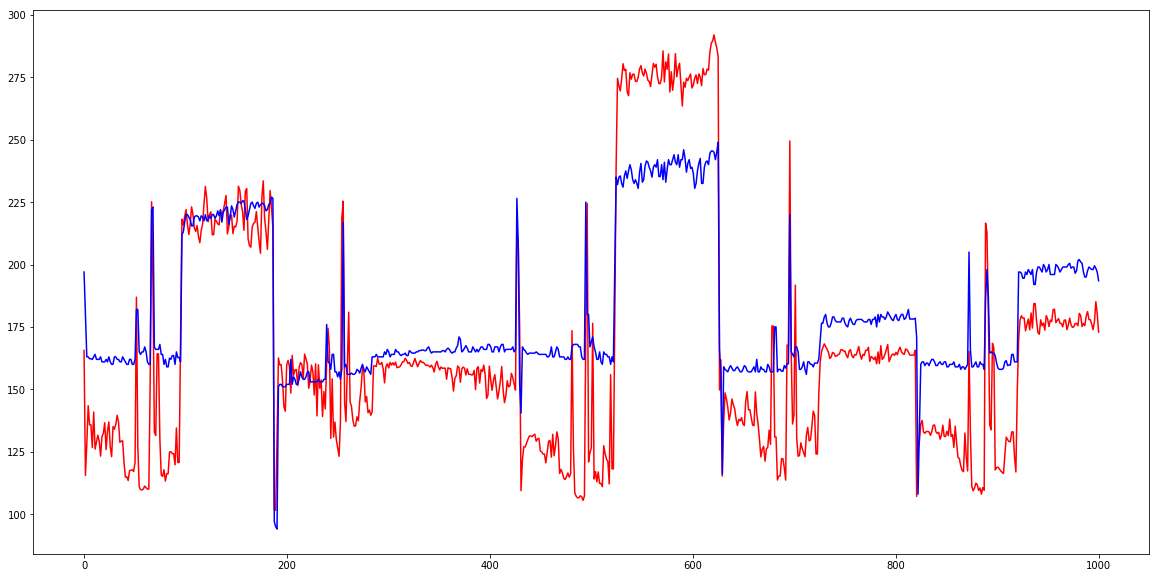

In [8]:
fig = plt.figure(figsize=(20,10))
#ax = plt.axes()

application = 'graph_analytics'
orig = pd.read_csv(os.path.join(validation_dir, application + '.csv'))

consumption_app = orig['powerWatts']
print(consumption_app.count())
pred_app = predictions_df[application]

pred_app = pred_app.loc[1:consumption_app.count()-1,]
consumption_app = consumption_app.loc[1:consumption_app.count()-1,]

x = np.linspace(0, 1000, consumption_app.count())


plt.plot(x, pred_app, color = 'red')
plt.plot(x, consumption_app, color = 'blue');

In [7]:
import os
import sys
import math
from cvxopt import matrix, solvers



# an implementation of Kernel Mean Matchin
# referenres:
#  1. Gretton, Arthur, et al. "Covariate shift by kernel mean matching." Dataset shift in machine learning 3.4 (2009): 5.
#  2. Huang, Jiayuan, et al. "Correcting sample selection bias by unlabeled data." Advances in neural information processing systems. 2006.
def kernel_mean_matching(X, Z, kern='lin', B=1.0, eps=None):
    nx = X.shape[0]
    nz = Z.shape[0]
    if eps == None:
        eps = B/math.sqrt(nz)
    if kern == 'lin':
        K = np.dot(Z, Z.T)
        kappa = np.sum(np.dot(Z, X.T)*float(nz)/float(nx),axis=1)
    elif kern == 'rbf':
        K = compute_rbf(Z,Z)
        kappa = np.sum(compute_rbf(Z,X),axis=1)*float(nz)/float(nx)
    else:
        raise ValueError('unknown kernel')
        
    K = matrix(K)
    kappa = matrix(kappa)
    G = matrix(np.r_[np.ones((1,nz)), -np.ones((1,nz)), np.eye(nz), -np.eye(nz)])
    h = matrix(np.r_[nz*(1+eps), nz*(eps-1), B*np.ones((nz,)), np.zeros((nz,))])
    
    sol = solvers.qp(K, -kappa, G, h)
    coef = np.array(sol['x'])
    return coef

def compute_rbf(X, Z, sigma=1.0):
    K = np.zeros((X.shape[0], Z.shape[0]), dtype=float)
    for i, vx in enumerate(X):
        K[i,:] = np.exp(-np.sum((vx-Z)**2, axis=1)/(2.0*sigma))
    return K

     pcost       dcost       gap    pres   dres
 0: -2.4472e+03 -2.7746e+05  4e+05  1e-01  4e-15
 1: -1.4815e+03 -1.8177e+05  2e+05  6e-02  4e-15
 2: -9.8646e+02 -3.1861e+04  3e+04  2e-16  2e-15
 3: -1.6087e+03 -1.4883e+04  1e+04  6e-17  1e-15
 4: -2.0345e+03 -7.1832e+03  5e+03  2e-16  7e-16
 5: -2.2601e+03 -4.7196e+03  2e+03  3e-16  4e-16
 6: -2.5524e+03 -3.4883e+03  9e+02  2e-16  3e-16
 7: -2.6903e+03 -2.8002e+03  1e+02  1e-16  3e-16
 8: -2.7193e+03 -2.7350e+03  2e+01  2e-16  1e-16
 9: -2.7245e+03 -2.7263e+03  2e+00  1e-16  2e-16
10: -2.7252e+03 -2.7254e+03  2e-01  2e-16  2e-16
11: -2.7253e+03 -2.7253e+03  3e-02  7e-17  2e-16
12: -2.7253e+03 -2.7253e+03  5e-03  1e-16  3e-16
13: -2.7253e+03 -2.7253e+03  7e-04  8e-17  2e-16
Optimal solution found.


24

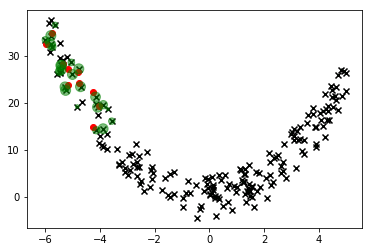

In [36]:
x = 11*np.random.random(200)- 6.0
y = x**2 + 10*np.random.random(200) - 5
Z = np.c_[x, y]

x = 2*np.random.random(10) - 6.0
y = x**2 + 10*np.random.random(10) - 5
X = np.c_[x, y]

coef = kernel_mean_matching(X, Z, kern='rbf', B=10)

plt.close()
plt.figure()
plt.scatter(Z[:,0], Z[:,1], color='black', marker='x')
plt.scatter(X[:,0], X[:,1], color='red')
plt.scatter(Z[:,0], Z[:,1], color='green', s=coef*10, alpha=0.5)

np.sum(coef > 1e-2)

In [21]:
coef.shape

(200, 1)

In [234]:
validation_split = 10000
#validation_split = 53400


test = './data_test.csv'
train = './training_48.csv'
#train =  './bscgrid31_training_equalized_46.csv'
train_file_location = './bscgrid31_training_42.csv'
#train_file_location =  './bscgrid31_training_equalized_46.csv'
validation_dir = './validation_pca/'


train_data = pd.read_csv(train_file_location)
train_data = train_data.drop(['Unnamed: 0'],1)

print(train_data.shape)

#df.dropna()

(102967, 42)


In [235]:
tranformed_columns = ['powerWatts', 'contexts', 'instructions', 'cpu.cycles', 'branches', 'branch.misses', 'L1.icache.loads',
                       'L1.dcache.loads', 'REQUESTS_TO_L2', 'RETIRED_UOPS', 'bytes_out', 'cpu_idle', 'cpu_system']#9 features
train_data = train_data.loc[:,tranformed_columns]

train_data = train_data.values#Numpy array
#Randomize training data
random_index = []
a = np.arange(len(train_data))
np.random.shuffle(a)
random_index = a[:len(train_data)]

train_data_orig = deepcopy(train_data)

i=0
for j in random_index:
    train_data[i] = train_data_orig[j]
    i += 1



#Data normalization
x_train = train_data[:validation_split,1:]#Used for normalizing testing data
y_train = train_data[:validation_split,0]

mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

nFeatures = train_data.shape[1]-1
print('nFeatures: ',nFeatures)
y_train


nFeatures:  12


array([ 98. , 161.5, 189. , ..., 234.5, 239.5, 188. ])

In [236]:
test_data = pd.read_csv(test)
test_data = test_data.loc[:,tranformed_columns]
print(test_data.shape)

(27591, 13)


In [237]:
test_data = test_data.values
x_test = test_data[:,1:]
x_test -= mean
x_test /= std
y_test = test_data[:27590,0]
y_test
x_test.shape[1]
#print(x_test)

12

In [238]:
weights = []
counter = 0
for i in range(1,x_test.shape[1]):
    x = x_train[:,i]
    y = y_train
    Z = np.c_[x, y]

    x = x_test[:27590,i]
    y = y_test
    X = np.c_[x, y]

    coef = kernel_mean_matching(X, Z, kern='rbf', B=10)
    
    weights.append(coef)
    
    if counter == 0:
        weights_df = pd.DataFrame(coef, columns=[str(tranformed_columns[i])])
    else:
        weights_df2 = pd.DataFrame(coef, columns=[str(tranformed_columns[i])])
        weights_df = pd.merge(weights_df, weights_df2, how='outer',left_index=True,right_index=True)
        
    counter +=1
    coef = 0

    #plt.close()
    #plt.figure()
    #plt.scatter(Z[:,0], Z[:,1], color='black', marker='x')
    #plt.scatter(X[:,0], X[:,1], color='red')
    #plt.scatter(Z[:,0], Z[:,1], color='green', s=coef*10, alpha=0.3)

    np.sum(coef > 1e-2)

weights_df.to_csv('weights.csv', sep=',')

     pcost       dcost       gap    pres   dres
 0: -1.2151e+06 -1.0048e+08  1e+09  7e-01  1e-13
 1: -1.1703e+06 -1.0471e+08  1e+09  6e-01  1e-13
 2: -5.6985e+05 -1.2991e+08  4e+08  8e-02  2e-14
 3: -4.6601e+05 -1.2590e+08  3e+08  6e-02  2e-14
 4: -2.4822e+05 -4.2126e+07  4e+07  1e-15  2e-14
 5: -3.9271e+05 -1.5328e+07  1e+07  1e-17  5e-14
 6: -5.0440e+05 -1.2789e+07  1e+07  2e-16  4e-14
 7: -6.8202e+05 -6.8021e+06  6e+06  3e-16  7e-14
 8: -8.1606e+05 -3.6486e+06  3e+06  2e-15  2e-14
 9: -9.0118e+05 -2.2673e+06  1e+06  1e-15  1e-14
10: -9.4100e+05 -1.7444e+06  8e+05  1e-15  1e-14
11: -9.6290e+05 -1.4594e+06  5e+05  4e-16  6e-15
12: -9.7823e+05 -1.2606e+06  3e+05  1e-15  3e-15
13: -9.8609e+05 -1.2735e+06  3e+05  4e-16  3e-15
14: -9.9850e+05 -1.1256e+06  1e+05  2e-16  1e-15
15: -1.0042e+06 -1.0647e+06  6e+04  1e-15  9e-16
16: -1.0074e+06 -1.0342e+06  3e+04  4e-16  8e-16
17: -1.0090e+06 -1.0184e+06  9e+03  1e-15  9e-16
18: -1.0096e+06 -1.0131e+06  4e+03  2e-15  9e-16
19: -1.0098e+06 -1.01

24: -9.8650e+05 -9.8651e+05  9e+00  3e-16  9e-16
25: -9.8650e+05 -9.8651e+05  5e+00  1e-15  8e-16
26: -9.8650e+05 -9.8651e+05  1e+00  1e-15  9e-16
27: -9.8650e+05 -9.8650e+05  6e-01  1e-17  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2127e+06 -1.0080e+08  2e+08  4e-02  1e-14
 1: -1.1958e+06 -9.9352e+07  2e+08  4e-02  1e-14
 2: -4.4892e+05 -7.5260e+07  9e+07  8e-03  2e-14
 3: -5.2445e+05 -1.0719e+07  1e+07  6e-04  3e-15
 4: -9.0597e+05 -5.1703e+06  4e+06  2e-04  4e-15
 5: -1.0974e+06 -2.4873e+06  1e+06  4e-05  2e-15
 6: -1.1392e+06 -2.1423e+06  1e+06  2e-05  1e-15
 7: -1.1797e+06 -1.6733e+06  5e+05  9e-06  1e-15
 8: -1.1993e+06 -1.4244e+06  2e+05  3e-06  9e-16
 9: -1.2051e+06 -1.3524e+06  1e+05  1e-06  8e-16
10: -1.2110e+06 -1.2715e+06  6e+04  4e-07  8e-16
11: -1.2138e+06 -1.2451e+06  3e+04  2e-07  7e-16
12: -1.2153e+06 -1.2266e+06  1e+04  5e-08  8e-16
13: -1.2158e+06 -1.2208e+06  5e+03  1e-08  8e-16
14: -1.2161e+06 -1.2174e+06  1e+03  2e-09  8e-

In [233]:
weights_df

,contexts,instructions,cpu.cycles,branches,branch.misses,L1.icache.loads,L1.dcache.loads,REQUESTS_TO_L2,RETIRED_UOPS,bytes_out,cpu_idle
0,6.850989e-02,6.725841e-02,6.828791e-02,0.066608,6.736266e-02,6.805956e-02,6.814284e-02,6.857053e-02,1.419869e-02,6.680855e-02,0.068985
1,4.947000e-01,4.935209e-01,4.962281e-01,0.487223,4.974916e-01,4.923348e-01,4.939819e-01,4.915281e-01,2.073294e-01,4.358418e-01,0.494069
2,5.034742e-02,9.237868e-01,1.011714e+00,1.129561,6.366958e-01,1.402065e-01,2.419755e-02,4.206143e-02,9.767932e-01,9.794504e-01,0.878891
3,1.454132e+00,1.029276e+00,1.407589e+00,0.000007,1.263318e+00,1.300050e+00,1.307118e+00,2.042091e-07,9.197595e-01,1.342296e+00,0.000084
4,5.114255e-07,2.403794e-01,7.598321e-07,0.000002,8.334304e-07,1.167518e-05,3.609004e-01,2.987831e-01,7.787281e-07,7.161832e-06,0.280226
5,3.838530e-01,4.208318e-01,1.868084e-01,0.105519,2.577615e-01,6.777325e-01,3.550534e-01,4.311498e-01,4.926952e-05,4.381544e-01,0.414542
6,4.508557e-01,4.556332e-01,4.329162e-01,0.357011,3.914803e-01,4.141866e-01,4.466322e-01,4.707571e-01,2.502457e-01,6.752924e-01,0.492805
7,9.744134e-01,3.440585e-01,2.658643e-01,0.745283,7.890594e-01,1.317442e-01,1.014944e-01,1.032267e+00,1.444144e-06,4.028553e-01,0.680156
8,7.719603e-01,2.364483e+00,1.793881e+00,2.934029,1.862719e+00,1.052027e-06,8.619469e-01,1.690251e-01,1.763993e+00,2.581434e+00,2.896760
9,3.928691e-01,1.616895e-01,3.421483e-01,0.098776,2.518068e-01,3.589784e-01,3.253764e-01,2.943883e-01,3.031273e-02,1.815260e-01,0.000059
